In [1]:
recipes_DF = spark.read.json("dbfs:/FileStore/tables/train.json", multiLine=True)

In [2]:
# INSPECT THE SIZE OF OUR DATA

import re

def to_standard(string):
  return string.replace("_", " ").upper().encode("utf-8") 

n_recipes_by_cuisine_RDD = (recipes_DF.rdd
                            .map(lambda r : (to_standard(r["cuisine"]), 1))
                            .reduceByKey(lambda a, b : a + b)
                            .cache())

n_occurences_per_ingredient_RDD = (recipes_DF.rdd
                                   .flatMap(lambda r : r["ingredients"])
                                   .map(lambda i : (to_standard(i), 1))
                                   .reduceByKey(lambda a, b : a + b)
                                   .cache())

avg_ingredients_by_cuisine_RDD = (recipes_DF.rdd
                                  .map(lambda r : (to_standard(r["cuisine"]), (len(r["ingredients"]), 1)))
                                  .reduceByKey(lambda a, b : (a[0] + b[0], a[1] + b[1]))
                                  .map(lambda (c, t) : (c, float(t[0]) / t[1]))
                                  .cache())

print "No. of Recipes: %s" % recipes_DF.rdd.count()
print "No. of Cuisines: %s" % n_recipes_by_cuisine_RDD.count()
print "No. of Ingredients: %s" % n_occurences_per_ingredient_RDD.count()

No. of Recipes: 39774
No. of Cuisines: 20
No. of Ingredients: 6703

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()

BAR_WIDTH = 0.8
LABEL_SIZE = 7

def plot_bar_chart(data, color='b'):
  index = np.arange(len(data))
  fig, ax = plt.subplots()
  
  plt.subplot(1, 1, 1)
  plt.bar(index, [tuple[1] for tuple in data], BAR_WIDTH, color=color)
  plt.xticks(index + BAR_WIDTH / 2, [tuple[0].replace(" ", "\n") for tuple in data], rotation="vertical")
  plt.tick_params(labelsize=LABEL_SIZE)
  
  display(fig)

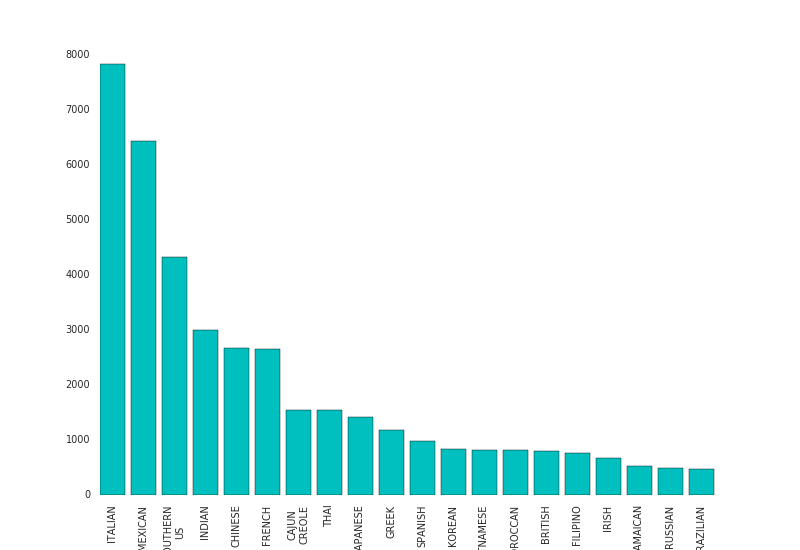

In [4]:
# GRAPH OF THE NO. OF RECIPES PER CUISINE

plot_bar_chart(n_recipes_by_cuisine_RDD.takeOrdered(20, lambda (c, sum) : -1 * sum), color='c')

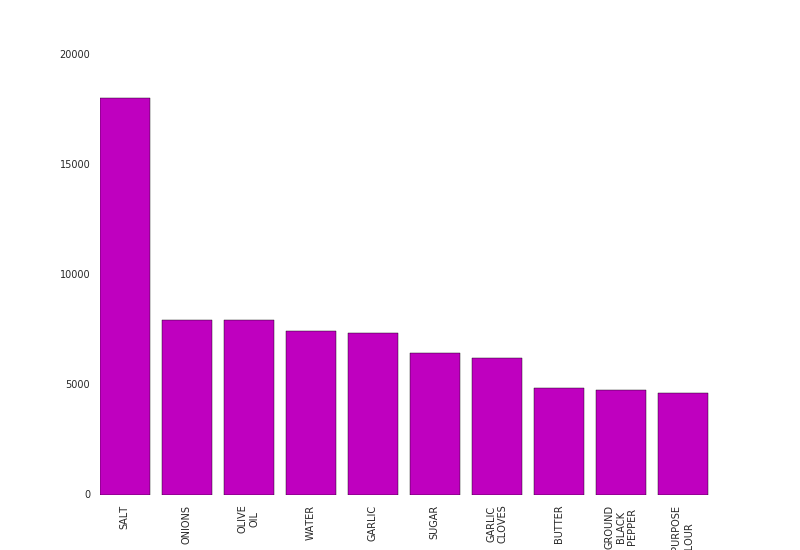

In [5]:
# GRAPH OF THE FREQUENCY OF OCCURENCE OF EACH INGREDIENT, ACROSS CUISINES

plot_bar_chart(n_occurences_per_ingredient_RDD.takeOrdered(10, lambda (i, sum) : -1 * sum), color='m')

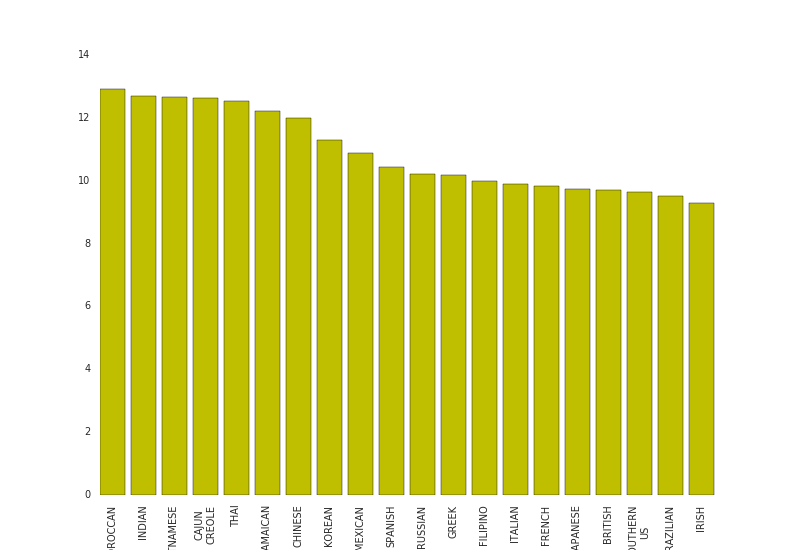

In [6]:
# GRAPH OF THE AVERAGE NO. OF INGREDIENTS USED PER RECIPE, BY CUISINE

plot_bar_chart(avg_ingredients_by_cuisine_RDD.takeOrdered(20, lambda (c, avg) : -1 * avg), color='y')

In [7]:
# SEPARATE DATA INTO TRAINING AND TEST SETS

WEIGHTS = [0.99, 0.01]

train_recipes_RDD, test_recipes_RDD = (recipes_DF.rdd
                                       .randomSplit(WEIGHTS))

train_recipes_RDD = (train_recipes_RDD
                     .map(lambda r : (to_standard(r["cuisine"]), {to_standard(i): 1 for i in r["ingredients"]}))
                     .cache())

test_recipes_RDD = (test_recipes_RDD
                    .map(lambda r : (to_standard(r["cuisine"]), [to_standard(i) for i in r["ingredients"]]))
                    .cache())

print "No. of Samples in Training Set: %s" % train_recipes_RDD.count()
print "No. of Samples in Test Set: %s" % test_recipes_RDD.count()

No. of Samples in Training Set: 39385
No. of Samples in Test Set: 389

In [8]:
# CALCULATE NORMALIZED RELATIVE FREQUENCIES PER INGREDIENT, BY CUISINE

def combine_dict(this, other):
  for key, value in other.iteritems():
    if this.has_key(key):
      this[key] += other[key]
    else:
      this[key] = other[key]
      
  return this

normalized_frequencies_RDD = (train_recipes_RDD
                              .reduceByKey(lambda a, b : combine_dict(a, b))
                              .map(lambda (c, i) : (c, {k: len(i) * float(v) / sum(i.values()) for k, v in i.iteritems()}))
                              .cache())

In [9]:
# TAKE A LOOK AT THE VALUES (SANITY CHECK)

ORDER = -1

def sort_by_value(dict):
  sorted_keys = sorted(dict, key=lambda x : ORDER * dict[x])
  output = []
  
  for key in sorted_keys:
      output.append((key, dict[key]))
      
  return output

sorted_aggregated_ingredients_RDD = (aggregated_ingredients_RDD
                                     .map(lambda (c, i) : (c, sort_by_value(i))))

sorted_normalized_frequencies_RDD = (normalized_frequencies_RDD
                                     .map(lambda (c, i) : (c, sort_by_value(i))))

def display_frequencies(dict, n=5):
  output = []
  for cuisine, ingredients in dict:
    string = "%s -" % cuisine
    for i in range(n):
      string += "\n\t%s: %s" % (ingredients[i][0], ingredients[i][1])     
    output.append(string)
    
  print "\n\n".join(output)

n = 5

print "RAW FREQUENCIES (TOP %s INGREDIENTS)" % n
print "-----------------------------------"
display_frequencies(sorted_aggregated_ingredients_RDD.collect(), n)

print ""

print "NORMALIZED RELATIVE FREQUENCIES (TOP %s INGREDIENTS)" %n
print "---------------------------------------------------"
display_frequencies(sorted_normalized_frequencies_RDD.collect(), n)

RAW FREQUENCIES (TOP 5 INGREDIENTS)
-----------------------------------
IRISH -
	SALT: 374
	ALL-PURPOSE FLOUR: 218
	BUTTER: 218
	ONIONS: 131
	SUGAR: 120

MEXICAN -
	SALT: 2697
	ONIONS: 1477
	GROUND CUMIN: 1329
	GARLIC: 1302
	OLIVE OIL: 1275

CHINESE -
	SOY SAUCE: 1354
	SESAME OIL: 907
	SALT: 898
	CORN STARCH: 896
	SUGAR: 817

FILIPINO -
	SALT: 418
	GARLIC: 322
	ONIONS: 307
	WATER: 306
	SOY SAUCE: 248

VIETNAMESE -
	FISH SAUCE: 388
	SUGAR: 340
	SALT: 263
	GARLIC: 239
	WATER: 226

SPANISH -
	SALT: 455
	OLIVE OIL: 380
	GARLIC CLOVES: 283
	ONIONS: 248
	EXTRA-VIRGIN OLIVE OIL: 248

SOUTHERN US -
	SALT: 2260
	BUTTER: 1240
	ALL-PURPOSE FLOUR: 1205
	SUGAR: 1044
	LARGE EGGS: 736

JAPANESE -
	SOY SAUCE: 555
	SALT: 416
	MIRIN: 399
	SUGAR: 396
	WATER: 375

MOROCCAN -
	OLIVE OIL: 408
	SALT: 407
	GROUND CUMIN: 342
	ONIONS: 275
	GARLIC CLOVES: 221

GREEK -
	SALT: 567
	OLIVE OIL: 497
	DRIED OREGANO: 266
	GARLIC CLOVES: 252
	FETA CHEESE CRUMBLES: 250

INDIAN -
	SALT: 1913
	ONIONS: 1180
	GARAM MASALA: 848
	WATER: 811
	GROUND TURMERIC: 719

JAMAICAN -
	SALT: 332
	ONIONS: 173
	WATER: 153
	GARLIC: 139
	GROUND ALLSPICE: 128

BRITISH -
	SALT: 404
	ALL-PURPOSE FLOUR: 235
	BUTTER: 218
	MILK: 200
	UNSALTED BUTTER: 191

BRAZILIAN -
	SALT: 192
	ONIONS: 131
	OLIVE OIL: 117
	LIME: 88
	WATER: 87

RUSSIAN -
	SALT: 285
	SUGAR: 153
	ONIONS: 144
	ALL-PURPOSE FLOUR: 122
	SOUR CREAM: 116

THAI -
	FISH SAUCE: 624
	GARLIC: 410
	SALT: 396
	COCONUT MILK: 350
	VEGETABLE OIL: 333

ITALIAN -
	SALT: 3425
	OLIVE OIL: 3083
	GARLIC CLOVES: 1604
	GRATED PARMESAN CHEESE: 1569
	GARLIC: 1460

KOREAN -
	SOY SAUCE: 423
	SESAME OIL: 402
	GARLIC: 300
	GREEN ONIONS: 291
	SUGAR: 264

FRENCH -
	SALT: 1195
	SUGAR: 633
	ALL-PURPOSE FLOUR: 589
	UNSALTED BUTTER: 589
	BUTTER: 511

CAJUN CREOLE -
	SALT: 735
	ONIONS: 525
	GARLIC: 366
	GREEN BELL PEPPER: 335
	BUTTER: 333

NORMALIZED RELATIVE FREQUENCIES (TOP 5 INGREDIENTS)
---------------------------------------------------
IRISH -
	SALT: 60.4143997394
	ALL-PURPOSE FLOUR: 35.0793288809
	BUTTER: 34.9169245806
	ONIONS: 21.2749633491
	POTATOES: 19.3261117446

MEXICAN -
	SALT: 103.807697858
	ONIONS: 57.1694567915
	GROUND CUMIN: 51.3444986434
	GARLIC: 50.4572533626
	OLIVE OIL: 48.9142180916

CHINESE -
	SOY SAUCE: 75.9996227246
	SESAME OIL: 50.8720721854
	CORN STARCH: 50.6477190556
	SALT: 50.6477190556
	SUGAR: 45.880215047

FILIPINO -
	SALT: 52.6197032482
	GARLIC: 40.8843737468
	ONIONS: 38.8653923272
	WATER: 38.6130196498
	SOY SAUCE: 31.6727710199

VIETNAMESE -
	FISH SAUCE: 41.4492809574
	SUGAR: 36.4412701477
	SALT: 27.9169964289
	GARLIC: 25.2531608918
	WATER: 24.0810732555

SPANISH -
	SALT: 56.3142801214
	OLIVE OIL: 47.4420084173
	GARLIC CLOVES: 35.2426348243
	EXTRA-VIRGIN OLIVE OIL: 31.17617696
	ONIONS: 30.9297249682

SOUTHERN US -
	SALT: 134.961710507
	BUTTER: 73.469222541
	ALL-PURPOSE FLOUR: 71.919993193
	SUGAR: 62.0883454077
	LARGE EGGS: 44.0338649293

JAPANESE -
	SOY SAUCE: 58.4020633643
	SALT: 43.513206995
	MIRIN: 42.0452915783
	SUGAR: 41.8355893759
	WATER: 39.2143118461

MOROCCAN -
	SALT: 37.8666413734
	OLIVE OIL: 37.5909134023
	GROUND CUMIN: 31.8006260078
	ONIONS: 25.5507919947
	GARLIC CLOVES: 20.4038698663

GREEK -
	SALT: 57.0832699298
	OLIVE OIL: 50.5277707329
	DRIED OREGANO: 26.7262659565
	GARLIC CLOVES: 25.3143122834
	FETA CHEESE CRUMBLES: 25.1126046158

INDIAN -
	SALT: 84.3253997572
	ONIONS: 51.9363818671
	GARAM MASALA: 37.5169138213
	WATER: 35.5884743258
	GROUND TURMERIC: 31.8192516756

JAMAICAN -
	SALT: 45.1835006274
	ONIONS: 23.5501882058
	WATER: 20.6748745295
	GARLIC: 18.8949184442
	GROUND ALLSPICE: 17.3888017566

BRITISH -
	SALT: 60.4078169195
	ALL-PURPOSE FLOUR: 35.4372589355
	BUTTER: 33.0448701466
	MILK: 30.2039084598
	EGGS: 28.5591411674

BRAZILIAN -
	SALT: 36.9936305732
	ONIONS: 25.4331210191
	OLIVE OIL: 22.5429936306
	LIME: 16.9554140127
	WATER: 16.7627388535

RUSSIAN -
	SALT: 50.3174924166
	SUGAR: 26.5662285137
	ONIONS: 25.5106167846
	ALL-PURPOSE FLOUR: 21.2881698686
	SOUR CREAM: 20.5844287159

THAI -
	FISH SAUCE: 44.281523

In [10]:
from pyspark.ml.feature import Word2Vec

all_ingredients_RDD = (n_occurences_per_ingredient_RDD
                       .map(lambda (i, sum) : (i.split(" "), )))

all_ingredients_DF = spark.createDataFrame(all_ingredients_RDD.collect(), ["text"])

word2Vec = Word2Vec(vectorSize=50, minCount=0, inputCol="text", outputCol="result")
model = word2Vec.fit(all_ingredients_DF)

results = {" ".join(text): vector for text, vector in model.transform(all_ingredients_DF).collect()}

In [11]:
def check_similarity(a, b):
  print a
  print b
  
  x = results.get(a)
  y = results.get(b)
  
  if x == None or y == None:
    return -1
  else:
    return x.dot(y) / (x.norm(2) * y.norm(2))

N = 10
M = 3

to_compare_RDD = (n_occurences_per_ingredient_RDD
              .sortBy(lambda (i, sum) : 1 * sum))

to_compare = [t[0] for t in to_compare_RDD.take(N)]

output = []
for ingredient in to_compare:
  cosine_similarities_RDD = (n_occurences_per_ingredient_RDD
                             .map(lambda (i, sum) : i)
                             .map(lambda i : (i, check_similarity(ingredient, i))))
  
  most_similar = cosine_similarities_RDD.takeOrdered(M + 1, lambda (i, similarity) : -1 * similarity)
  
  string = "%s -" % ingredient
  for i, similarity in most_similar:
    if not i == ingredient:
      string += "\n\t%s: %s" % (i, round(similarity, 3))
  
  output.append(string)

print "\n\n".join(output)

TOPSIDE STEAK -
	STEAK: 0.824
	CALAMARI STEAK: 0.749
	RUMP STEAK: 0.705

ICING MIX -
	SOUR MIX: 0.857
	STUFFING MIX: 0.827
	CAKE MIX: 0.817

KRAFT ORIGINAL BARBECUE SAUCE -
	BARBECUE SAUCE: 0.928
	HOISIN SAUCE: 0.915
	ASIAN BARBECUE SAUCE: 0.914

SKINLESS CHICKEN BREAST FILLETS -
	SKINLESS CHICKEN FILLETS: 0.992
	CHICKEN BREAST FILLETS: 0.989
	BONELESS CHICKEN BREAST: 0.987

BONED SKINNED DUCK BREAST HALVES -
	SKINNED BONED DUCK BREAST HALVES: 1.0
	BONED DUCK BREAST HALVES: 0.987
	DUCK BREAST HALVES: 0.975

CAKE MIX OR WHITE YELLOW -
	WHITE CAKE MIX: 0.931
	MARTHA WHITE CORNBREAD MIX: 0.847
	JAMBALAYA RICE MIX: 0.837

CHAI TEA CONCENTRATE -
	FRESH OREGANO: 0.84
	FROZEN LEMONADE CONCENTRATE: 0.836
	SWEET TEA: 0.814

ESSENCE SEASONING -
	SEASONING: 0.823
	BLACKENING SEASONING: 0.783
	SOUTHWEST SEASONING: 0.75

PINEAPPLE CHUNKS IN NATURAL JUICE -
	FRESH LEMON JUICE: 0.932
	CRUSHED PINEAPPLES IN JUICE: 0.93
	TUNA IN OIL: 0.918

CASTELVETRANO OLIVES -
	OLIVES: 0.814
	GREEN OLIVES: 0.72
	SLICED GREEN OLIVES: 0.695

In [12]:
# 'FORWARD PROPAGATE' SINGLE-LAYER NETWORK AND CALCULATE ACCURACY

def calculate_class_value(frequencies, ingredients):
  sum = 0
  for i in ingredients:
    if i in frequencies:
      print i
      sum += frequencies[i]
  
  return sum

sum_correct = 0
sum_in_top_3 = 0

for cuisine, recipe in test_recipes_RDD.collect():
  output_RDD = (normalized_frequencies_RDD
                .map(lambda (c, i) : (c, calculate_class_value(i, recipe)))
                .cache())
  
  predictions = [c for c, value in output_RDD.takeOrdered(3, lambda (c, value) : -1 * value)]
  
  if cuisine == predictions[0]:
    sum_correct += 1
    
  if cuisine in predictions:
    sum_in_top_3 += 1
    
  # print "INGREDIENTS: %s" % ", ".join(recipe)
  # print "TOP 3 PREDICTIONS: %s" % ", ".join([c for c, value in predictions])
  # print "ACTUAL: %s" % cuisine
  # print ""

l = test_recipes_RDD.count()

print "Accuracy: %s" % round(float(sum_exactly_right) / l, 3)
print "In Top 3: %s" % round(float(sum_in_top_3) / l, 3)